In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to size 224x224
# ResNet takes input 224x224 image size and better preprocessing
# size depends on type of images and type of dataset
IMAGE_SIZE = [224, 224]

# Training Data path
train_path = r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Train'

# Test Data path
valid_path = r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Test'

In [3]:
# Initialize ResNet50 with same images
# Import the ResNet50 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
# input shape = 224x224x3 => 3 channels will be there(RGB) for resnet architecture => add index '3' at the last
# weights = imagenet => use same weights that the resnet50 has been trained on imagenet images => properly utilize ResNet50
# include_top = False => In ResNet50, there are 1000 output categories by default, but we need only 3 categories as output
#                   => Dont have to include first and last
# In topmost layer => need to provide own dataset

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# We will not be having the first and last layers in the architecture as we need to give our own images and output(categories)

resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
# don't train existing weights
# Resuse the already existing weights

# Traverse each and every layer of the resnet
for layer in resnet.layers:
    layer.trainable = False

In [6]:
# Use the glob function to see how many folders(categories) are present in neural network
folders = glob(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Train\*')

In [7]:
folders

['C:\\Users\\Lenovo\\Desktop\\New folder\\python\\Car Brand Dataset\\Train\\audi',
 'C:\\Users\\Lenovo\\Desktop\\New folder\\python\\Car Brand Dataset\\Train\\lamborghini',
 'C:\\Users\\Lenovo\\Desktop\\New folder\\python\\Car Brand Dataset\\Train\\mercedes']

In [8]:
# Flatten the resnet output
# Flattening required before connecting to a fully connecting layer
x = Flatten()(resnet.output)

In [9]:
# Use Dense layer to set the length of folders as the number of outputs
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
# output => dense layer with 3 nodes and activation function as softmax which is used to classify multiple categories
model = Model(inputs=resnet.input, outputs=prediction)

In [10]:
# view the structure of the model
# last layer => has 3 output nodes to identify each category
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',   
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
# Apply Data Augmentation technique to create image dataset
# Data Augmentation => Generate new images using variations in the available images
# ImageDataGenerator => reads images from folder and apply augmentation techniques
# For image augmentation => need to scale down the image values(width, height, RGB channels)
# divide all the pixels by 255 => gets converted to values ranging 0 to 1
# Should never do data augmentation in test data except rescaling

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
# Read all the images from the training folder and apply augmentation techniques to all the training images
# target size => should be same as the initial size used in the model => 224 x 224
# class_mode => 'categorical' => when using more than 2 classes and 'binary' => when =2 classes

training_set = train_datagen.flow_from_directory(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [14]:
test_set = test_datagen.flow_from_directory(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [15]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
2/2 [==============================] - 22s 12s/step - loss: 3.3757 - accuracy: 0.4479 - val_loss: 14.1129 - val_accuracy: 0.1552
Epoch 2/50
2/2 [==============================] - 15s 10s/step - loss: 11.7134 - accuracy: 0.3229 - val_loss: 7.0513 - val_accuracy: 0.5172
Epoch 3/50
2/2 [==============================] - 16s 11s/step - loss: 8.0968 - accuracy: 0.2812 - val_loss: 5.5720 - val_accuracy: 0.3276
Epoch 4/50
2/2 [==============================] - 15s 10s/step - loss: 7.0218 - accuracy: 0.3854 - val_loss: 8.5039 - val_accuracy: 0.3276
Epoch 5/50
2/2 [==============================] - 15s 11s/step - loss: 6.7799 - accuracy: 0.3854 - val_loss: 3.7833 - val_accuracy: 0.1552
Epoch 6/50
2/2 [==============================] - 17s 12s/step - loss: 2.5460 - accuracy: 0.4271 - val_loss: 3.0205 - val_accuracy: 0.3793
Epoch 7/50
2/2 [==============================] - 16s 11s/step - loss: 3.1161 - accuracy: 0.5208 - val_loss: 4.2003 - val_accuracy: 0.5172
Epoch 8/50
2/2 [=========

In [16]:
r.history

{'loss': [4.222313404083252,
  10.668420791625977,
  7.464639663696289,
  7.314945697784424,
  6.303221702575684,
  2.799711227416992,
  3.334733486175537,
  3.3934385776519775,
  1.348391056060791,
  2.6636791229248047,
  2.195610284805298,
  0.9817674160003662,
  1.7696568965911865,
  1.1587884426116943,
  1.1003570556640625,
  1.110508680343628,
  0.8080951571464539,
  1.094475507736206,
  0.630454421043396,
  0.9083483815193176,
  0.47110337018966675,
  0.703596293926239,
  0.5591851472854614,
  0.602837324142456,
  0.463718444108963,
  0.48240458965301514,
  0.4400244355201721,
  0.3739289939403534,
  0.2975057363510132,
  0.34176772832870483,
  0.3006349205970764,
  0.3528748154640198,
  0.32084938883781433,
  0.2896554470062256,
  0.325217068195343,
  0.2991206645965576,
  0.2900882363319397,
  0.24925662577152252,
  0.25379228591918945,
  0.2626107335090637,
  0.24209387600421906,
  0.23441514372825623,
  0.2680172920227051,
  0.24260936677455902,
  0.2368949055671692,
  0.3059

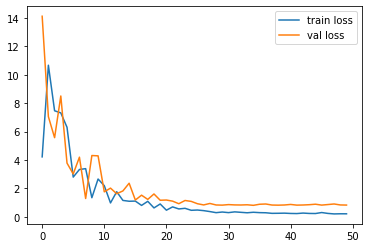

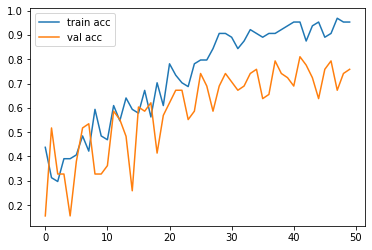

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

The validation accuracy is increasing the same way as the training accuracy thus indicating good performance using transfer learning. To reduce the difference add more images to training dataset

In [18]:
# save the model as h5 file => data saved in heirarchial data format(HDF), used to save multidimensional arrays of data 
from tensorflow.keras.models import load_model

model.save(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Prediction\model_resnet50.h5')

In [19]:
# Prediction for the test dataset => Probabilities based on 3 classes => [audi, lamborghini, mercedes]
y_pred = model.predict(test_set)
y_pred

array([[2.08340473e-02, 9.50842798e-01, 2.83231307e-02],
       [6.13288907e-03, 9.76053417e-01, 1.78136826e-02],
       [9.18461382e-01, 5.61010353e-02, 2.54376475e-02],
       [1.35696409e-05, 4.67759231e-03, 9.95308816e-01],
       [1.07128672e-01, 5.15928745e-01, 3.76942635e-01],
       [4.31502573e-02, 4.32133675e-01, 5.24716079e-01],
       [3.60616073e-02, 9.67569463e-03, 9.54262674e-01],
       [7.00806528e-02, 6.14129126e-01, 3.15790147e-01],
       [2.57699043e-02, 6.75784528e-01, 2.98445642e-01],
       [2.16542301e-03, 9.92364049e-01, 5.47052734e-03],
       [4.51834537e-02, 9.43860173e-01, 1.09564373e-02],
       [8.65323562e-03, 7.38060892e-01, 2.53285974e-01],
       [6.14491880e-01, 3.30515563e-01, 5.49925976e-02],
       [3.17029371e-05, 1.95279170e-03, 9.98015523e-01],
       [6.90227598e-02, 2.15599999e-01, 7.15377271e-01],
       [2.99334358e-02, 1.22432131e-02, 9.57823336e-01],
       [2.39724517e-01, 6.02748156e-01, 1.57527357e-01],
       [5.16026467e-03, 7.56589

In [20]:
# Take the index with the maximum probability for each record in test data(58 values)
# 0th index is audi, 1st index is lamborghini, 2nd index is mercedes
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2], dtype=int64)

In [21]:
# Prediction for new dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model=load_model(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Prediction\model_resnet50.h5')

In [22]:
# Read one image for the prediction from the Test dataset
# Target size => 224x224
img=image.load_img(r'C:\Users\Lenovo\Desktop\New folder\python\Car Brand Dataset\Test\lamborghini\11.jpg',target_size=(224,224))

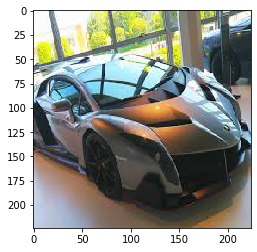

In [23]:
plt.imshow(img)

In [24]:
# Convert image to an array as the imagedatagen also converts the images to an array
x=image.img_to_array(img)
x

array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [196., 187., 172.],
        [217., 208., 193.],
        [243., 234., 219.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 245., 237.],
        [243., 243., 235.],
        [242., 242., 234.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [240., 249., 248.],
        [242., 251., 250.],
        [242., 251., 250.]],

       ...,

       [[189., 207., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 206., 227.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 2

In [25]:
x.shape

(224, 224, 3)

In [26]:
# In test data => we did the rescaling by dividing by 255
# For new data also => need to divide by 255
x=x/255

In [27]:
# Expand the dimensions
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [28]:
# Predict the output
model.predict(img_data)

array([[1.2572514e-03, 1.2184658e-04, 9.9862087e-01]], dtype=float32)

In [29]:
# Take the maximum value
a=np.argmax(model.predict(img_data), axis=1)

In [30]:
a

array([2], dtype=int64)